## Distance predictor with simple NN

A simple self-supervised setting to predict the number of moves it takes to reach final position

This is a starting place to check things like state space representation (does using state = [1, 2, 3, 1] work), and just generally how well NNs can approximate permutation problems.

### Basic outline:

- Generate a set of `n'` moves by uniformly sampling from available actions, with `n'` randomly sampled from some probability distribution
- Using greedy_reduce to simplify those moves to get `n` number of moves, $n \leq n'$
- Apply these `n` moves on a puzzle to reach `start_state`
- Batch produce pairs of `x = start_state, y = n`
- A network $\mathcal{F}$ takes `start_state` as input, and the target output is `n'`

### Some preliminary details

- Loss function: mean square loss
- Neural network weights: $|s| \times 128$, $128 \times 128$, $128 \times 1$
- For 2x2 puzzles, we only need up to 10 - 14 moves
- State-space representation should be normalized?

### Some hypotheses

- Expecting better performance on low `n` over high `n`
- Expecting weird things to happen at `n` > 10.


In [1]:
import json
from typing import Dict, List
from collections import OrderedDict


import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn

from tqdm import tqdm

In [2]:
%pprint

Pretty printing has been turned OFF


In [3]:
from src.mechanism.permute import reverse_perm, permute_with_swap, perm_to_swap
from src.mechanism.utils import get_inverse_move
from src.mechanism.reduce import iterate_reduce_sequence

### Load a puzzle 
Since each puzzle is trained separately 

In [60]:
def load_puzzle_moves(
    puzzle_name: str, convert_to_swaps=True
) -> (Dict[str, List[int]], int):
    """Retrieves and returns the moves and final position of the puzzle"""
    # load the moves:
    with open(f"puzzles/{puzzle_name}/moves.json") as f:
        moves = json.load(f)

    num_states = len(list(moves.values())[0])
    # add reversed moves
    reversed_moves = {}
    for move_name, perm in moves.items():
        reversed_perm = reverse_perm(perm)
        if reversed_perm == perm:
            continue
        reversed_moves[f"-{move_name}"] = reversed_perm

    moves.update(reversed_moves)

    if convert_to_swaps:
        for move_name, perm in moves.items():
            moves[move_name] = perm_to_swap(perm)

    # get final position (from the first puzzle), note that the actual state of this position doesn't really matter
    # we just need to get the structure of the puzzle
    df = pd.read_csv(f"puzzles/{puzzle_name}/puzzles.csv")
    state = df.iloc[0].to_numpy()[3].split(";")
    c = -1
    mapping = {}
    for i, s in enumerate(state):
        if s not in mapping.keys():
            c += 1
            mapping[s] = c
        state[i] = mapping[s]

    return moves, num_states, state


puzzle_name = "cube_3x3x3"
move_dict, num_states, final_state = load_puzzle_moves(puzzle_name)

move_names = np.array(list(move_dict.keys()))

# final_state = list(range(num_states))

print(f"Loaded {puzzle_name} with {len(move_names)} moves and {num_states} states")

Loaded cube_3x3x3 with 18 moves and 54 states


### Data generation

The self-supervised part: Generate a set of `n` moves by uniformly sampling from available actions, with `n` randomly sampled from some probability distribution

In [61]:
def sample_moves(move_names: List[str], n: int) -> List[int]:
    return np.random.choice(move_names, n)


def generate_state_from_moves(move_names, move_dict, state, inverse=False):
    for move_name in move_names:
        if inverse:
            move_name = get_inverse_move(move_name)
        move = move_dict[move_name]
        state = permute_with_swap(state, move)

    return state


def normalize_state(state):
    if type(state) == list:
        n = len(set(state)) - 1
        return [s / n for s in state]
    return state / len(state)


path = list(sample_moves(move_names, 15))

print(path)

path = iterate_reduce_sequence(path, puzzle_name)
n = len(path)
print(path)
print(n)

state = generate_state_from_moves(path, move_dict, final_state)
print(state)
normalize_state(state)

['r2', 'd0', 'd0', '-d1', 'd1', 'f2', 'r2', 'f0', 'd2', '-d2', '-d2', '-f1', 'r2', 'd1', 'f0']
['r2', 'd0', 'd0', 'f2', 'r2', 'f0', '-d2', '-f1', 'r2', 'd1', 'f0']
11
[3, 5, 5, 3, 2, 4, 5, 0, 3, 1, 4, 4, 1, 0, 2, 1, 2, 1, 0, 3, 1, 0, 1, 1, 4, 1, 0, 4, 4, 2, 0, 5, 0, 3, 3, 3, 5, 5, 2, 3, 3, 2, 4, 4, 2, 0, 5, 0, 1, 4, 5, 5, 2, 2]


[0.6, 1.0, 1.0, 0.6, 0.4, 0.8, 1.0, 0.0, 0.6, 0.2, 0.8, 0.8, 0.2, 0.0, 0.4, 0.2, 0.4, 0.2, 0.0, 0.6, 0.2, 0.0, 0.2, 0.2, 0.8, 0.2, 0.0, 0.8, 0.8, 0.4, 0.0, 1.0, 0.0, 0.6, 0.6, 0.6, 1.0, 1.0, 0.4, 0.6, 0.6, 0.4, 0.8, 0.8, 0.4, 0.0, 1.0, 0.0, 0.2, 0.8, 1.0, 1.0, 0.4, 0.4]

In [62]:
class Sampler:
    def __init__(self) -> None:
        pass

    def sample(self) -> int:
        pass


class Uniform_sampler(Sampler):
    def __init__(self, low, high) -> None:
        super().__init__()
        self.low = low
        self.high = high

    def sample(self) -> int:
        return np.random.randint(self.low, self.high)


class Constant_sampler(Sampler):
    def __init__(self, n) -> None:
        super().__init__()
        self.n = n

    def sample(self) -> int:
        return self.n

In [63]:
def generate_single_sample(sampler):
    # TODO: shouldn't use variables from outside scope like this
    n = sampler.sample()
    moves = list(sample_moves(move_names, n))
    moves = iterate_reduce_sequence(moves, puzzle_name)
    x = generate_state_from_moves(moves, move_dict, final_state)
    x = normalize_state(x)
    y = len(moves)

    return torch.tensor(x), y

### create a batch of data

In [153]:
def generate_batch(num_samples, sampler):
    X = torch.empty(num_samples, num_states, dtype=torch.float32, requires_grad=False)
    Y = torch.empty(num_samples, dtype=torch.float32, requires_grad=False)
    for i in range(num_samples):
        x, y = generate_single_sample(sampler)
        X[i, :] = x
        Y[i] = y
    return X, Y


sampler = Uniform_sampler(4, 5)
X, Y = generate_batch(10, sampler)

tensor(4.)


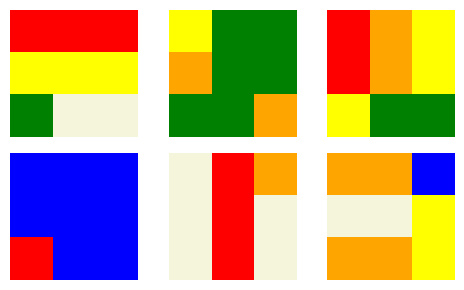

In [154]:
from matplotlib.colors import ListedColormap


def imshow_cube(x):
    cmap = ListedColormap(["red", "green", "yellow", "blue", "beige", "orange"])
    num_states = len(x)
    face_size = len(x) // 6
    dim = int(face_size**0.5)

    plt.figure(figsize=(5, 3))

    for k in range(6):
        face = x[k * face_size : (k + 1) * face_size]
        plt.subplot(2, 3, k + 1)
        plt.imshow(
            face.reshape(dim, dim),
            vmin=0,
            vmax=1,
            cmap=cmap,
        )
        plt.axis("off")
    plt.tight_layout()


i = np.random.randint(0, len(X))
imshow_cube(X[i])
print(Y[i])

### A simple network

In [155]:
class FFN(nn.Module):
    def __init__(self, inp: int, units: List[int]):
        super().__init__()
        layers = []
        prev = inp
        for num_units in units:
            layers.append(nn.Linear(prev, num_units))
            layers.append(nn.BatchNorm1d(num_units))
            layers.append(nn.ReLU())
            prev = num_units

        layers.append(nn.Linear(units[-1], 1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)


net = FFN(inp=num_states, units=[128, 128])
print(net)

FFN(
  (layers): Sequential(
    (0): Linear(in_features=54, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)


### Train the network 

In [197]:
total_steps = 20
batch_size = 1000

net = FFN(inp=num_states, units=[64, 128, 64])
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.MSELoss()
sampler = Uniform_sampler(0, total_steps)
# sampler = Constant_sampler(5)

history = []
net.train()
for e in tqdm(range(500)):
    X, Y = generate_batch(batch_size, sampler)
    optimizer.zero_grad()
    y_pred = net(X)
    loss = criterion(y_pred.squeeze(), Y)
    loss.backward()
    optimizer.step()
    history.append(loss.item())

100%|██████████| 500/500 [00:44<00:00, 11.23it/s]


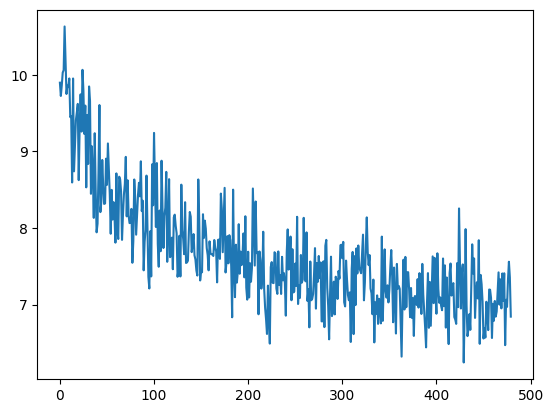

In [198]:
plt.plot(history[20:])

### Error Analysis


In [203]:
sampler = Uniform_sampler(0, total_steps)
# sampler = Constant_sampler(0)
num_samples = 1000
num_batches = 10

total_errors = [0] * total_steps
total_samples = [0] * total_steps
total_preds = [0] * total_steps

with torch.no_grad():
    net.eval()
    for b in range(num_batches):
        X, Y = generate_batch(num_samples, sampler)
        y_pred = net(X)

        for y, y_p in zip(Y, y_pred):
            total_errors[int(y)] += criterion(y_p, y)
            total_samples[int(y)] += 1
            total_preds[int(y)] += y_p

print(sum(total_errors)/sum(total_samples))

tensor(6.9531)


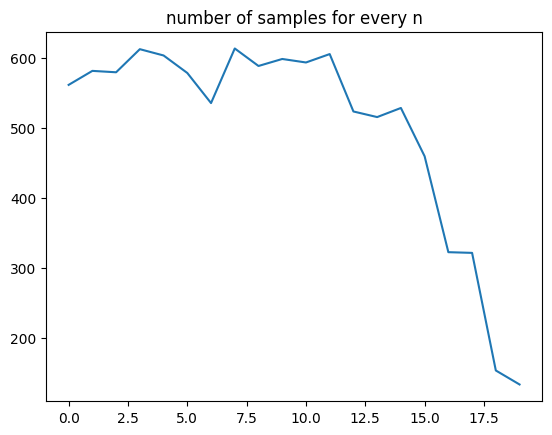

In [204]:
plt.title('number of samples for every n')
plt.plot(total_samples)

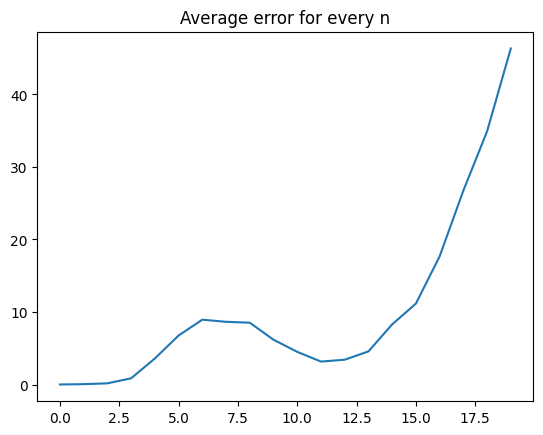

In [205]:
plt.title("Average error for every n")
plt.plot([e / n for (e, n) in zip(total_errors, total_samples)])

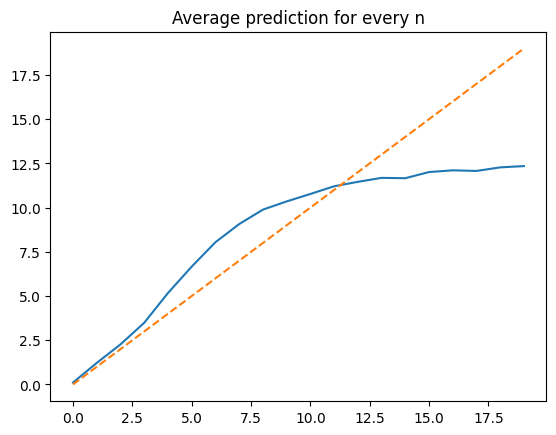

In [206]:
plt.title("Average prediction for every n")
plt.plot([y / n for (y, n) in zip(total_preds, total_samples)])
plt.plot(range(total_steps), '--')

### Train with state space being the colors 